# Imports

In [299]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from src.visualization.visualize import plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load environment variables
load_dotenv(find_dotenv())

True

In [3]:
# Load dataset from pickle file
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname = data_base_dir + '/processed/djia_cleaned_2019-12-11.pkl'
djia = pickle.load(open(fname, 'rb'))

In [4]:
#MomentumIndicators(MSDataManager().ReturnData('AAPL', limit=100)['Close']).calcMACD(12, 26,)

In [580]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]

# Target variable

## Forecast Horizon

The target of this project is to forecast future price movements of a given asset based on the different technical indicators. Technical indicators are mathematical formulas intended which reflect the past price movements. It is assumed that history will (at least partially) be repeated in the future.

In order to build a supervised machine learning model, we need a target variable. Here, we will use two different classifications for predicting the future price trend: A two label classification scheme (1: up, 0: down), and a three label classification scheme (1: up; 0: no movement; -1: down). In both cases, the relative future price change is used to label the training and test data set:
$$y(t)=\frac{C_{t+n}-C_t}{C_t}$$


### Two-class classification

For the two label classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt 0$ }\\0, & \text{if $ y(t)\lt 0$ } \\\end{cases}$$

In [816]:
dicti = {}
def create_two_class_signal(df, symbol_list):
    for symbol in symbol_list:
        data = df[symbol]
        for n in forecast_horizon:
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal = np.where(diff > 0, 1, 0)
            dicti[f'{symbol}_signal_{n}'] = signal

In [817]:
dicti = {}
create_two_class_signal(djia, ['AAPL'], )
y_2c = pd.DataFrame(dicti)

array([0.52184273, 0.47815727])

In [860]:
lis = []
cols = []
for x in y_2c.columns:
    v = y_2c[x].value_counts()
    lis.append((v.to_list()/v.sum()))
    cols.append(x)
df = pd.DataFrame(lis).T
df.columns = cols

In [861]:
df

,AAPL_signal_1,AAPL_signal_3,AAPL_signal_5,AAPL_signal_7,AAPL_signal_10,AAPL_signal_15,AAPL_signal_20,AAPL_signal_25,AAPL_signal_30
0,0.521843,0.556791,0.574265,0.591739,0.589357,0.602065,0.618745,0.602859,0.608419
1,0.478157,0.443209,0.425735,0.408261,0.410643,0.397935,0.381255,0.397141,0.391581


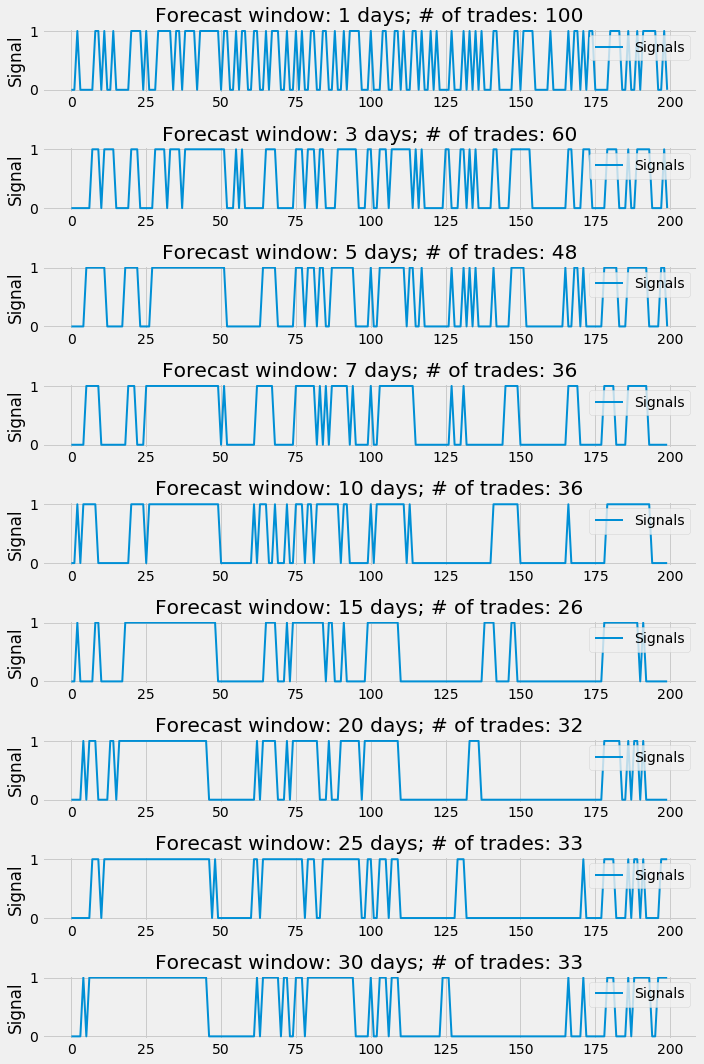

In [813]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
for i, n in enumerate(forecast_horizon):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(y_2c[f'AAPL_signal_{n}'][:window], lw=2, label='Signals')
    #plt.plot(y_3c[f'AAPL_open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_2c[f'AAPL_signal_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

### Three class classification

For the three class classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt \delta$ }\\0, & \text{if $-\delta \leq y(t)\leq \delta$ } \\-1, & \text{if $ y(t)\lt -\delta$ }\end{cases}$$

where the threshold $\delta$ is a parameter of the strategy that needs tuning.

In [864]:
threshold_list = [0.63, 1.15, 1.49, 1.79, 2.14, 2.65, 3.08, 3.48, 3.94]

In [865]:
def create_three_class_signal(df, symbol_list, threshold=0.02, multi=None):
    if type(threshold) != 'list':
        threshold = [threshold]*len(forecast_horizon)
    for symbol in symbol_list:
        data = df[symbol]
        for i, n in enumerate(forecast_horizon):
            if multi is not None:
                threshold[i] = threshold[i]*multi
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            #thr = threshold*multi
            signal1p = np.where(diff > threshold[i], 1, 0)
            signal1n = np.where(diff < -threshold[i], -1, 0)
            signal = signal1p + signal1n
            is_invested = False
            open_position = [0]*len(signal)
            for i in range(len(signal)):
                if signal[i] == 1 or (signal[i] == 0 and is_invested == True):
                    open_position[i] = 1
                    is_invested = True
                else:
                    open_position[i] = 0
                    is_invested = False
            dicti[f'{symbol}_signal_{n}'] = signal
            dicti[f'{symbol}_open_position_{n}'] = open_position

In [866]:
dicti = {}
create_three_class_signal(djia, ['AAPL'], 0.01)
y_3c = pd.DataFrame(dicti)

In [867]:
y_3c.head()

,AAPL_signal_1,AAPL_open_position_1,AAPL_signal_3,AAPL_open_position_3,AAPL_signal_5,AAPL_open_position_5,AAPL_signal_7,AAPL_open_position_7,AAPL_signal_10,AAPL_open_position_10,AAPL_signal_15,AAPL_open_position_15,AAPL_signal_20,AAPL_open_position_20,AAPL_signal_25,AAPL_open_position_25,AAPL_signal_30,AAPL_open_position_30
0,0,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0
1,-1,0,-1,0,-1,0,-1,0,-1,0,0,0,-1,0,-1,0,-1,0
2,1,1,0,0,-1,0,-1,0,0,0,0,0,-1,0,-1,0,0,0
3,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0,0,0
4,0,0,-1,0,-1,0,0,0,0,0,-1,0,0,0,-1,0,1,1


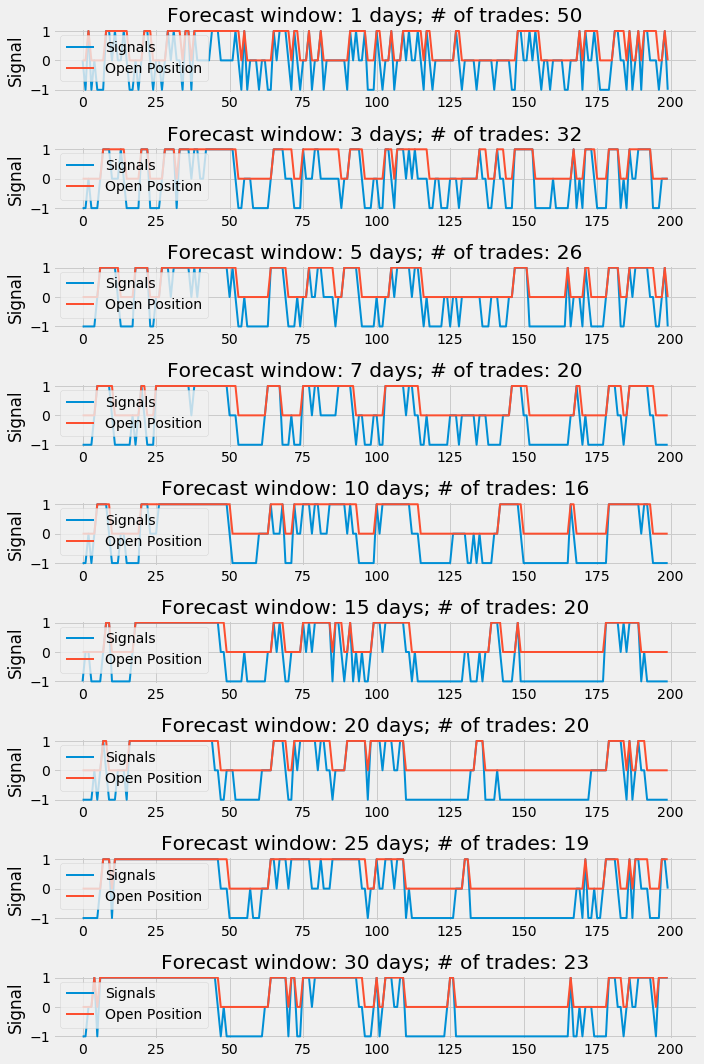

In [868]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
for i, n in enumerate(input_n):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(y_3c[f'AAPL_signal_{n}'][:window], lw=2, label='Signals')
    plt.plot(y_3c[f'AAPL_open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_3c[f'AAPL_open_position_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

In [466]:
input_n

[1, 3, 5, 7, 10, 15, 20, 25, 30]

In [467]:
y = signals_true

In [468]:
y.head()

,AAPL_signal_3,AAPL_signal_5,AAPL_signal_7,AAPL_signal_10,AAPL_signal_15,AAPL_signal_20,AAPL_signal_25,AAPL_signal_30
0,0,-1,-1,0,0,-1,-1,-1
1,0,-1,-1,0,0,-1,-1,-1
2,0,-1,0,0,0,-1,0,0
3,-1,-1,0,0,-1,0,-1,0
4,-1,0,0,0,0,0,-1,0


In [469]:
y.reset_index(inplace=True)

# Feature Engineering

Input window length:
[3, 5, 7, 10, 15, 20, 25, 30]

1. MACD x
2. RSI x
3. ROC x
4. BB x
5. SMA x
6. EMA x
7. ATR x
8. ADX x
9. CCI x
10. WILLIAMSR x
11. STOCK_n x
12. STOCD EMA_n(STOCK) x

In [562]:
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
def calcIndicators(data, symbol):
    mi = MomentumIndicators(data[symbol])
    df = pd.DataFrame(index=data.index)
    for n in input_window_size:
        # 1) MACD 
        df[f'{symbol}_macd_{n}'] = mi.calcMACD(n, 2*n)
        # 2) RSI
        df[f'{symbol}_rsi_{n}'] = mi.calcRSI(n)
        # 3) STOC
        df[f'{symbol}_stoc_{n}'] = mi.calcSTOC(n)
        # 4) ROC
        df[f'{symbol}_roc_{n}'] = mi.calcROC(n)
        # 5) Bollinger Bands
        df[f'{symbol}_bbu_{n}'], df[f'{symbol}_bbl_{n}'] = mi.calcBB(n)
        # 6) EMA
        df[f'{symbol}_ema_{n}'] = mi.calcEMA(n)
        # 7) ATR
        df[f'{symbol}_atr_{n}'] = mi.calcATR(n)
        # 8) ADX
        df[f'{symbol}_adx_{n}'] = mi.calcADX(n)
        # 9) CCI
        df[f'{symbol}_cci_{n}'] = mi.calcCCI(n)
        # 10) WilliamsR
        df[f'{symbol}_williamsr_{n}'] = mi.calcWR(n)
        # 11) STOCD
        df[f'{symbol}_stocd_{n}'] = mi.calcEMA(n, df[f'{symbol}_stoc_{n}'])
    return df

In [563]:
X = calcIndicators(djia, 'AAPL')

/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:129: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  latest = self.df['Close'].rolling(min_periods=1, window=n).apply(lambda x: x[-1:])
/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'roc_{n}'] = N / D
/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [472]:
X.tail()

,AAPL_macd_36,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
Epoch,,,,,,,,,,,,,,,,,,,,,
2019-11-27 00:00:00+00:00,0.949406,79.647823,100.000000,0.023149,271.407410,264.272583,266.106173,4.336670,30.354829,100.000000,...,100.000000,0.142808,288.530754,247.149239,254.942100,3.824665,34.275236,90.304217,0.464048,94.823906
2019-11-29 00:00:00+00:00,0.923253,57.074028,83.380328,0.003304,271.054564,263.445436,266.678086,3.483337,33.265621,50.209146,...,98.122824,0.135881,286.987788,247.512212,255.736158,3.806999,34.397893,87.604865,2.224859,95.036740
2019-12-02 00:00:00+00:00,0.119877,49.100932,0.000000,-0.000492,268.112937,260.207071,265.419045,3.529999,19.402720,-100.000000,...,86.800595,0.117381,282.626653,245.693354,256.279632,3.857331,32.536081,71.969522,13.197792,94.505376
2019-12-03 00:00:00+00:00,-1.193452,0.000000,0.000000,-0.031325,267.305877,251.594148,262.434529,3.869995,29.695304,-100.000000,...,69.906789,0.078749,276.834267,242.065758,256.484172,3.861664,33.016843,10.273487,28.396212,92.918370
2019-12-04 00:00:00+00:00,-1.001295,22.695597,48.619579,-0.020617,266.450580,257.029400,262.087259,4.456655,20.276281,1.062958,...,75.263564,0.090765,277.825339,245.654642,256.823257,3.904330,31.587192,38.818693,21.006804,91.779350


In [767]:
X.describe()

,AAPL_macd_3,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
count,1259.000000,1256.000000,1258.000000,1256.000000,1258.000000,1258.000000,1259.000000,1259.000000,1258.000000,1258.000000,...,1258.000000,1229.000000,1258.000000,1258.000000,1259.000000,1259.000000,1258.000000,1258.000000,1259.000000,1258.000000
mean,0.176647,54.900666,54.978335,0.002345,155.154878,149.013262,151.938565,2.912793,35.661170,9.389570,...,61.864806,0.025058,162.127061,142.041079,150.427258,2.898911,36.386338,29.118303,38.592255,60.806936
std,1.246807,34.388148,45.092480,0.026924,42.696012,40.973391,41.606114,1.618553,18.940392,80.153442,...,34.861399,0.090580,45.125115,38.997116,39.693827,1.201926,11.383475,113.143039,30.850640,23.656750
min,-5.113457,0.000000,0.000000,-0.103382,92.928516,85.093086,91.063328,0.000000,2.539166,-100.000000,...,0.000000,-0.295746,96.604255,74.698124,96.220068,0.000000,18.716978,-302.110322,0.000000,0.000000
25%,-0.439365,26.282627,0.000000,-0.012345,116.966869,112.367167,114.528497,1.803337,20.846431,-81.105711,...,30.504453,-0.027194,121.500409,108.302533,114.145912,2.023833,28.474194,-56.214245,10.286618,44.210391
50%,0.232191,57.323018,69.671622,0.002807,150.833111,144.340232,147.636185,2.459997,32.972528,33.465338,...,72.012712,0.032773,154.699934,138.059608,147.566045,2.543999,34.384036,50.559769,30.629991,63.496301
75%,0.888794,87.324544,100.000000,0.017143,186.996836,177.352766,182.011251,3.591670,48.090619,91.505203,...,94.791405,0.089226,197.091697,169.728391,181.668313,3.693165,41.515424,111.795252,64.654406,81.015487
max,4.238164,100.000000,100.000000,0.096074,271.676867,264.940296,266.678086,10.560000,100.000000,100.000000,...,100.000000,0.220493,292.318200,247.512212,256.823257,7.021334,100.000000,345.552893,100.000000,97.467982


In [474]:
X.shape

(1259, 96)

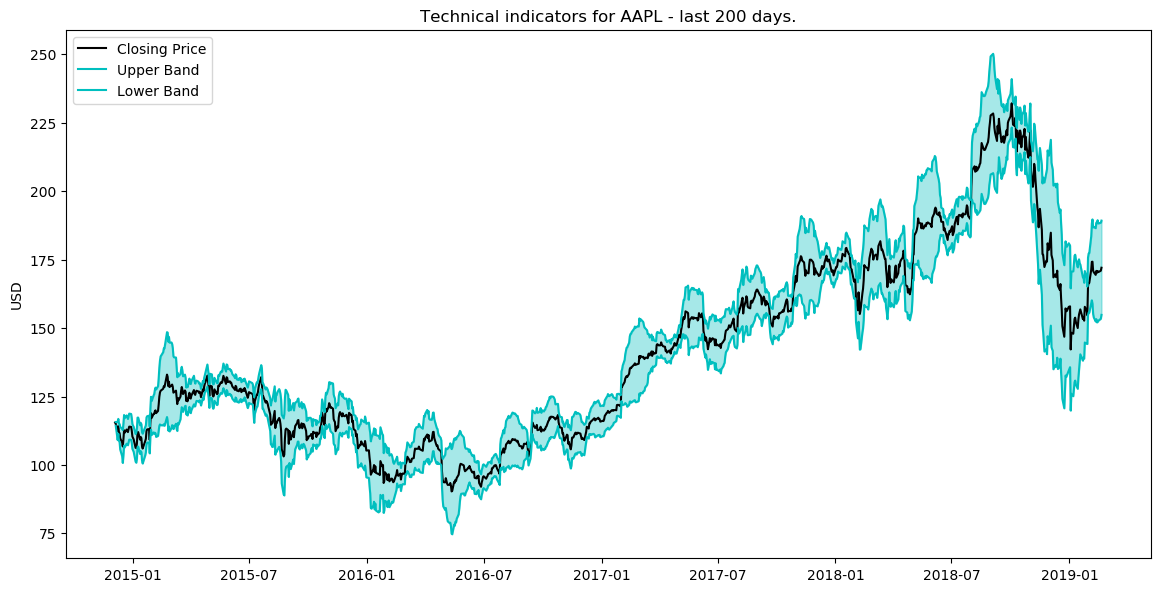

In [475]:
symbol = 'AAPL'

x_ = range(3, X.shape[0])
x_ = list(X.index)

last_days = 200
n = 30
#plt.fill_between()
plt.figure(figsize=(14, 7), dpi=100)
#plt.plot(dataset['ma7'], label='MA 7', color='g',linestyle='--')
plt.plot(djia[symbol]['Close'][:-last_days], label='Closing Price', color='k')
#plt.plot(X[symbol+'_macd1'],label='MACD 12, 26', color='r',linestyle='--')
plt.plot(X[f'{symbol}_bbu_{n}'][:-last_days], label='Upper Band', color='c')
plt.plot(X[f'{symbol}_bbl_{n}'][:-last_days], label='Lower Band', color='c')
plt.fill_between(X.index[:-last_days], X[f'{symbol}_bbu_{n}'][:-last_days], X[f'{symbol}_bbl_{n}'][:-last_days], color='c', alpha=0.35)
plt.title(f'Technical indicators for {symbol} - last {last_days} days.')
plt.ylabel('USD')
plt.legend()

In [476]:
#sns.pairplot(X.fillna(0))

In [477]:
X.fillna(0, inplace=True)

## Scaling the features

In [564]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [776]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [777]:
scaled = scale.fit_transform(X)

In [778]:
scaled.shape

(1259, 96)

In [779]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = X

In [780]:
X_scaled.describe()

,AAPL_macd_3,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
count,1.259000e+03,1.256000e+03,1.258000e+03,1.256000e+03,1.258000e+03,1.258000e+03,1.259000e+03,1.259000e+03,1.258000e+03,1.258000e+03,...,1.258000e+03,1229.000000,1.258000e+03,1258.000000,1.259000e+03,1.259000e+03,1.258000e+03,1.258000e+03,1.259000e+03,1.258000e+03
mean,-2.257483e-17,-1.244581e-16,1.779181e-16,2.121445e-17,-9.037110e-17,3.614844e-16,-1.805986e-16,-9.029932e-17,8.472290e-17,-2.259277e-17,...,-2.259277e-16,0.000000,3.614844e-16,0.000000,-9.029932e-17,-9.029932e-17,9.037110e-17,5.648193e-17,1.523801e-16,1.242603e-16
std,1.000397e+00,1.000398e+00,1.000398e+00,1.000398e+00,1.000398e+00,1.000398e+00,1.000397e+00,1.000397e+00,1.000398e+00,1.000398e+00,...,1.000398e+00,1.000407,1.000398e+00,1.000398,1.000397e+00,1.000397e+00,1.000398e+00,1.000398e+00,1.000397e+00,1.000398e+00
min,-4.244608e+00,-1.597136e+00,-1.219720e+00,-3.928423e+00,-1.458008e+00,-1.560662e+00,-1.463713e+00,-1.800343e+00,-1.749445e+00,-1.365295e+00,...,-1.775299e+00,-3.543121,-1.452603e+00,-1.727557,-1.366175e+00,-2.412846e+00,-1.552811e+00,-2.928685e+00,-1.251436e+00,-2.571406e+00
25%,-4.942687e-01,-8.325379e-01,-1.219720e+00,-5.458219e-01,-8.947720e-01,-8.947433e-01,-8.995056e-01,-6.857339e-01,-7.824880e-01,-1.129475e+00,...,-8.999301e-01,-0.577101,-9.006694e-01,-0.865499,-9.143931e-01,-7.283521e-01,-6.953317e-01,-7.545005e-01,-9.178702e-01,-7.018354e-01
50%,4.456633e-02,7.046954e-02,3.259774e-01,1.716291e-02,-1.012621e-01,-1.140957e-01,-1.034485e-01,-2.798650e-01,-1.420093e-01,3.004904e-01,...,2.912087e-01,0.085210,-1.646551e-01,-0.102137,-7.211069e-02,-2.954028e-01,-1.759655e-01,1.895830e-01,-2.581933e-01,1.137280e-01
75%,5.714037e-01,9.432550e-01,9.988266e-01,5.498362e-01,7.460795e-01,6.919314e-01,7.230821e-01,4.196008e-01,6.565013e-01,1.024888e+00,...,9.448759e-01,0.708703,7.751457e-01,0.710266,7.873635e-01,6.610809e-01,4.507521e-01,7.310200e-01,8.451205e-01,8.545801e-01
max,3.258829e+00,1.312001e+00,9.988266e-01,3.482576e+00,2.730192e+00,2.830450e+00,2.758852e+00,4.726595e+00,3.398262e+00,1.130912e+00,...,1.094344e+00,2.158473,2.886262e+00,2.705664,2.681482e+00,3.431211e+00,5.590469e+00,2.797878e+00,1.991276e+00,1.550324e+00


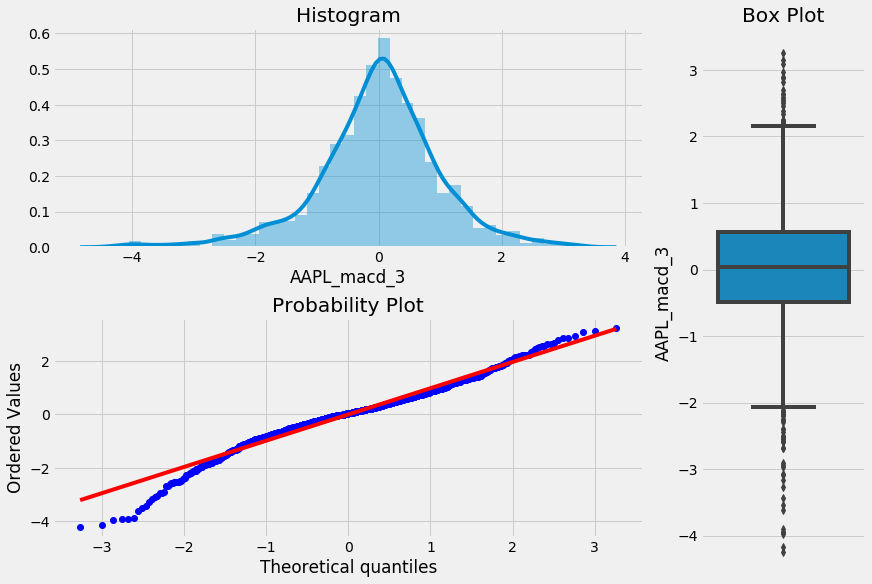

In [737]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
import matplotlib.style as style
from scipy import stats

style.use('fivethirtyeight')
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(X_scaled['AAPL_macd_3'], norm_hist=False, ax = ax1)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('QQ_plot')
stats.probplot(X_scaled['AAPL_macd_3'], plot = ax2)

ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Box Plot')
sns.boxplot(X_scaled['AAPL_macd_3'], orient='v', ax = ax3 );

## Building Machine Learning Models

In [532]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

### Train-Test Split

In [706]:
test_p = .4

In [781]:
test_size = int((1 - test_p) * X_scaled.shape[0])
col = 'AAPL_signal_30'
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]


In [782]:
X_test.shape

(504, 96)

In [869]:
test_size = test_p
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

In [870]:
X_test.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


### LogisticRegression

In [504]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=25, solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        84
           0       0.33      0.91      0.48        81
           1       0.75      0.50      0.60       213

    accuracy                           0.48       378
   macro avg       0.36      0.47      0.36       378
weighted avg       0.49      0.48      0.44       378

[[  0  56  28]
 [  0  74   7]
 [ 10  97 106]]


### RandomForestClassifier

              precision    recall  f1-score   support

          -1       0.17      0.05      0.07        84
           0       0.28      0.95      0.43        81
           1       0.68      0.25      0.36       213

    accuracy                           0.35       378
   macro avg       0.38      0.42      0.29       378
weighted avg       0.48      0.35      0.31       378

[[  4  59  21]
 [  0  77   4]
 [ 19 141  53]]


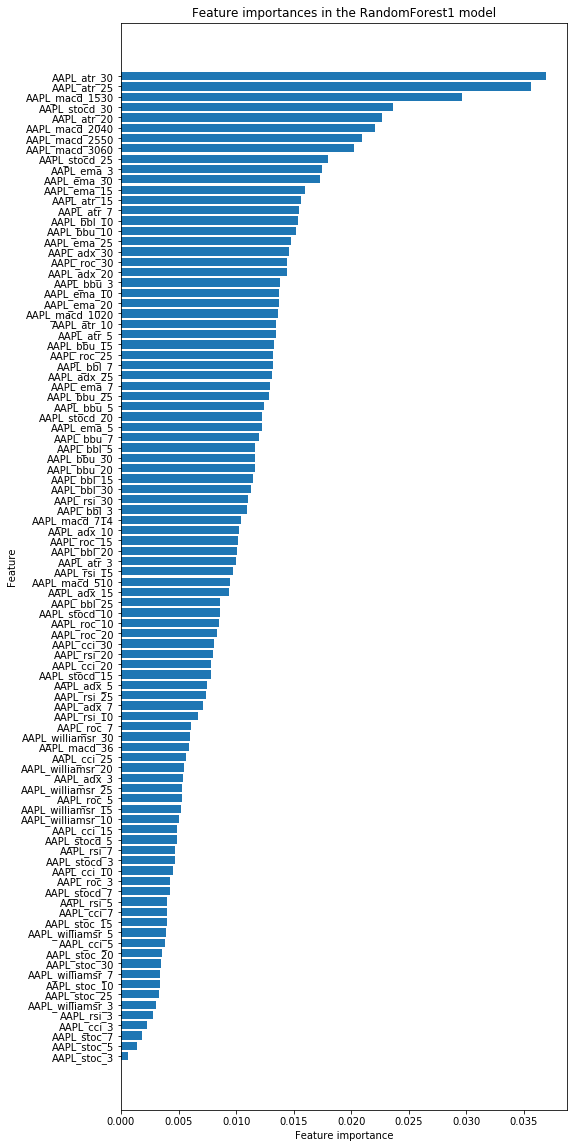

In [505]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)
print(classification_report(y_test, y_pred_rf1))
print(confusion_matrix(y_test, y_pred_rf1))
plot_feature_importances(rf1.feature_importances_, X_scaled.columns, model='RandomForest1', top_count=100)

#### All combinations

'Leg [72 / 72]; Score 0.8630952380952381'

Elapsed time (23, 0) s.


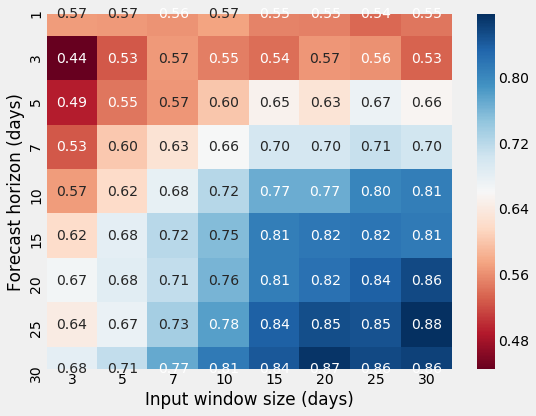

In [877]:
rf2 = RandomForestClassifier(criterion='entropy')
result_matrix = run_combinations('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, rf2)

### XGBoost

#### Single combination

In [871]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

symbol = 'AAPL'
col = 'AAPL_signal_3'
xgb = xgb.XGBClassifier(n_jobs=-1)
n = 30
xgb.fit(X_train[[f'{symbol}_{x}_{n}' for x in ti_list]], y_train[f'{symbol}_signal_{n}'])

#param_search = {'max_depth' : [3, 5]}

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [801]:
y_train.shape

(755, 18)

              precision    recall  f1-score   support

          -1       0.83      0.82      0.82       162
           0       0.61      0.25      0.36        55
           1       0.84      0.94      0.89       287

    accuracy                           0.83       504
   macro avg       0.76      0.67      0.69       504
weighted avg       0.81      0.83      0.81       504

[[133   4  25]
 [ 15  14  26]
 [ 13   5 269]]


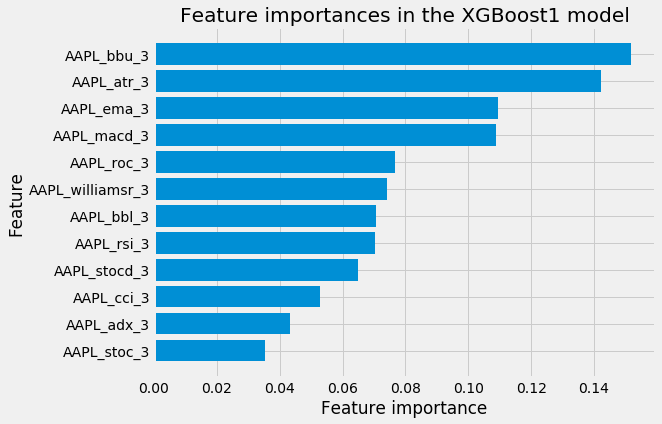

In [802]:
y_pred_xgb = xgb.predict(X_test[[f'{symbol}_{x}_{n}' for x in ti_list]])
print(classification_report(y_test[f'{symbol}_signal_{n}'], y_pred_xgb))
print(confusion_matrix(y_test[f'{symbol}_signal_{n}'], y_pred_xgb))
plot_feature_importances(xgb.feature_importances_, X_scaled.columns, model='XGBoost1', top_count=100)

#### All combinations

In [710]:
from  IPython.display import display, clear_output
import sys
import time

In [876]:
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']

def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        model,
        plot_results = True
    ):
    start = time.time()
    cnt = 1
    df = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    for i, fh in enumerate(forecast_horizon):
        for j, iw in enumerate(input_window_size):
            clear_output(wait=True)
            total = len(forecast_horizon)*len(input_window_size)
            model.fit(X_train[[f'{symbol}_{x}_{iw}' for x in ti_list]], y_train[f'{symbol}_signal_{fh}'])
            y_pred = model.predict(X_test[[f'{symbol}_{x}_{iw}' for x in ti_list]])
            a_score = accuracy_score(y_test[f'{symbol}_signal_{fh}'], y_pred)
            df.iloc[i, j] = a_score
            display(f'Leg [{cnt} / {total}]; Test Score {a_score}')
            #sys.stdout.flush()
            cnt += 1
    if plot_results:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df, annot=True, fmt='.2f', cmap='RdBu')
        plt.ylabel('Forecast horizon (days)')
        plt.xlabel('Input window size (days)')
        plt.tight_layout()
    print(f'Elapsed time {round(time.time()-start), 0} s.')
    return df

In [874]:
xgb_comb = xgb.XGBClassifier(n_jobs=-1)
result_matrix = run_combinations('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, xgb_comb)

AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

### Support Vector Machine

'Leg [72 / 72]; Score 0.7883597883597884'

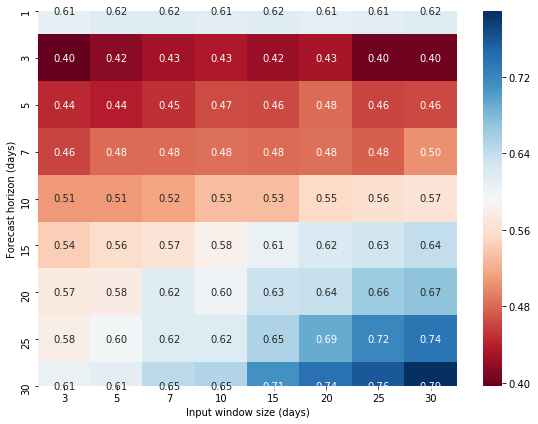

In [697]:
from sklearn.svm import SVC
svc = SVC()
result_matrix = run_combinations('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, svc)

In [696]:
X_test.fillna(0, inplace=True)

In [519]:
X_scaled.columns

Index(['AAPL_macd_36', 'AAPL_rsi_3', 'AAPL_stoc_3', 'AAPL_roc_3', 'AAPL_bbu_3',
       'AAPL_bbl_3', 'AAPL_ema_3', 'AAPL_atr_3', 'AAPL_adx_3', 'AAPL_cci_3',
       'AAPL_williamsr_3', 'AAPL_stocd_3', 'AAPL_macd_510', 'AAPL_rsi_5',
       'AAPL_stoc_5', 'AAPL_roc_5', 'AAPL_bbu_5', 'AAPL_bbl_5', 'AAPL_ema_5',
       'AAPL_atr_5', 'AAPL_adx_5', 'AAPL_cci_5', 'AAPL_williamsr_5',
       'AAPL_stocd_5', 'AAPL_macd_714', 'AAPL_rsi_7', 'AAPL_stoc_7',
       'AAPL_roc_7', 'AAPL_bbu_7', 'AAPL_bbl_7', 'AAPL_ema_7', 'AAPL_atr_7',
       'AAPL_adx_7', 'AAPL_cci_7', 'AAPL_williamsr_7', 'AAPL_stocd_7',
       'AAPL_macd_1020', 'AAPL_rsi_10', 'AAPL_stoc_10', 'AAPL_roc_10',
       'AAPL_bbu_10', 'AAPL_bbl_10', 'AAPL_ema_10', 'AAPL_atr_10',
       'AAPL_adx_10', 'AAPL_cci_10', 'AAPL_williamsr_10', 'AAPL_stocd_10',
       'AAPL_macd_1530', 'AAPL_rsi_15', 'AAPL_stoc_15', 'AAPL_roc_15',
       'AAPL_bbu_15', 'AAPL_bbl_15', 'AAPL_ema_15', 'AAPL_atr_15',
       'AAPL_adx_15', 'AAPL_cci_15', 'AAPL_williamsr_1

### XGBoost with GridSearchCV

In [510]:
param_search = {'max_depth': [3, 5]}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=xgb, cv=tscv,
                        param_grid=param_search)
gsearch.fit(X_scaled, y['AAPL_signal_30'])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None, param_grid={'max_depth': [3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
        

In [512]:
gsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [511]:
y_pred_xgbcv = gsearch.predict(X_test)
print(classification_report(y_test, y_pred_xgbcv))
print(confusion_matrix(y_test, y_pred_xgbcv))
plot_feature_importances(gsearch.feature_importances_, X_scaled.columns, model='XGBoostGridSearchCV', top_count=100)

ValueError: feature_names mismatch: ['AAPL_macd_36', 'AAPL_rsi_3', 'AAPL_stoc_3', 'AAPL_roc_3', 'AAPL_bbu_3', 'AAPL_bbl_3', 'AAPL_ema_3', 'AAPL_atr_3', 'AAPL_adx_3', 'AAPL_cci_3', 'AAPL_williamsr_3', 'AAPL_stocd_3', 'AAPL_macd_510', 'AAPL_rsi_5', 'AAPL_stoc_5', 'AAPL_roc_5', 'AAPL_bbu_5', 'AAPL_bbl_5', 'AAPL_ema_5', 'AAPL_atr_5', 'AAPL_adx_5', 'AAPL_cci_5', 'AAPL_williamsr_5', 'AAPL_stocd_5', 'AAPL_macd_714', 'AAPL_rsi_7', 'AAPL_stoc_7', 'AAPL_roc_7', 'AAPL_bbu_7', 'AAPL_bbl_7', 'AAPL_ema_7', 'AAPL_atr_7', 'AAPL_adx_7', 'AAPL_cci_7', 'AAPL_williamsr_7', 'AAPL_stocd_7', 'AAPL_macd_1020', 'AAPL_rsi_10', 'AAPL_stoc_10', 'AAPL_roc_10', 'AAPL_bbu_10', 'AAPL_bbl_10', 'AAPL_ema_10', 'AAPL_atr_10', 'AAPL_adx_10', 'AAPL_cci_10', 'AAPL_williamsr_10', 'AAPL_stocd_10', 'AAPL_macd_1530', 'AAPL_rsi_15', 'AAPL_stoc_15', 'AAPL_roc_15', 'AAPL_bbu_15', 'AAPL_bbl_15', 'AAPL_ema_15', 'AAPL_atr_15', 'AAPL_adx_15', 'AAPL_cci_15', 'AAPL_williamsr_15', 'AAPL_stocd_15', 'AAPL_macd_2040', 'AAPL_rsi_20', 'AAPL_stoc_20', 'AAPL_roc_20', 'AAPL_bbu_20', 'AAPL_bbl_20', 'AAPL_ema_20', 'AAPL_atr_20', 'AAPL_adx_20', 'AAPL_cci_20', 'AAPL_williamsr_20', 'AAPL_stocd_20', 'AAPL_macd_2550', 'AAPL_rsi_25', 'AAPL_stoc_25', 'AAPL_roc_25', 'AAPL_bbu_25', 'AAPL_bbl_25', 'AAPL_ema_25', 'AAPL_atr_25', 'AAPL_adx_25', 'AAPL_cci_25', 'AAPL_williamsr_25', 'AAPL_stocd_25', 'AAPL_macd_3060', 'AAPL_rsi_30', 'AAPL_stoc_30', 'AAPL_roc_30', 'AAPL_bbu_30', 'AAPL_bbl_30', 'AAPL_ema_30', 'AAPL_atr_30', 'AAPL_adx_30', 'AAPL_cci_30', 'AAPL_williamsr_30', 'AAPL_stocd_30'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95']
expected AAPL_macd_1530, AAPL_stocd_25, AAPL_bbu_20, AAPL_stocd_20, AAPL_adx_3, AAPL_bbl_3, AAPL_roc_7, AAPL_adx_30, AAPL_cci_15, AAPL_stoc_10, AAPL_williamsr_25, AAPL_stoc_25, AAPL_williamsr_20, AAPL_bbl_30, AAPL_adx_20, AAPL_stocd_30, AAPL_stocd_5, AAPL_rsi_10, AAPL_stoc_5, AAPL_atr_30, AAPL_rsi_3, AAPL_bbl_25, AAPL_atr_25, AAPL_atr_20, AAPL_adx_15, AAPL_bbl_5, AAPL_bbu_30, AAPL_ema_25, AAPL_williamsr_15, AAPL_bbu_25, AAPL_rsi_7, AAPL_cci_10, AAPL_atr_5, AAPL_stocd_15, AAPL_roc_3, AAPL_atr_10, AAPL_rsi_20, AAPL_stocd_10, AAPL_bbl_7, AAPL_ema_5, AAPL_stoc_30, AAPL_williamsr_3, AAPL_rsi_15, AAPL_cci_20, AAPL_bbu_15, AAPL_williamsr_10, AAPL_roc_10, AAPL_stoc_3, AAPL_cci_3, AAPL_rsi_5, AAPL_roc_30, AAPL_adx_5, AAPL_bbu_10, AAPL_bbl_20, AAPL_rsi_25, AAPL_adx_10, AAPL_macd_3060, AAPL_ema_30, AAPL_rsi_30, AAPL_atr_7, AAPL_stoc_15, AAPL_ema_3, AAPL_bbu_5, AAPL_williamsr_7, AAPL_stoc_20, AAPL_ema_10, AAPL_stocd_3, AAPL_bbl_15, AAPL_macd_714, AAPL_adx_7, AAPL_macd_36, AAPL_williamsr_30, AAPL_bbl_10, AAPL_cci_30, AAPL_atr_3, AAPL_ema_7, AAPL_macd_510, AAPL_roc_15, AAPL_stoc_7, AAPL_roc_5, AAPL_williamsr_5, AAPL_roc_25, AAPL_ema_15, AAPL_macd_1020, AAPL_bbu_7, AAPL_stocd_7, AAPL_roc_20, AAPL_macd_2550, AAPL_cci_7, AAPL_cci_5, AAPL_adx_25, AAPL_bbu_3, AAPL_cci_25, AAPL_atr_15, AAPL_macd_2040, AAPL_ema_20 in input data
training data did not have the following fields: f10, f94, f64, f38, f17, f85, f44, f81, f59, f3, f70, f82, f76, f18, f53, f55, f37, f62, f24, f22, f48, f66, f27, f13, f8, f34, f19, f86, f92, f58, f36, f80, f39, f77, f90, f88, f65, f20, f7, f87, f46, f72, f0, f78, f6, f5, f74, f33, f15, f40, f63, f54, f41, f12, f4, f71, f75, f95, f29, f14, f23, f73, f30, f50, f68, f45, f9, f60, f25, f16, f43, f11, f21, f47, f61, f89, f49, f93, f69, f26, f91, f79, f32, f83, f84, f2, f28, f67, f31, f56, f1, f57, f35, f42, f52, f51

              precision    recall  f1-score   support

          -1       0.82      0.80      0.81        88
           0       0.76      0.64      0.70       104
           1       0.84      0.93      0.88       186

    accuracy                           0.82       378
   macro avg       0.81      0.79      0.80       378
weighted avg       0.82      0.82      0.82       378

[[ 70  13   5]
 [ 10  67  27]
 [  5   8 173]]


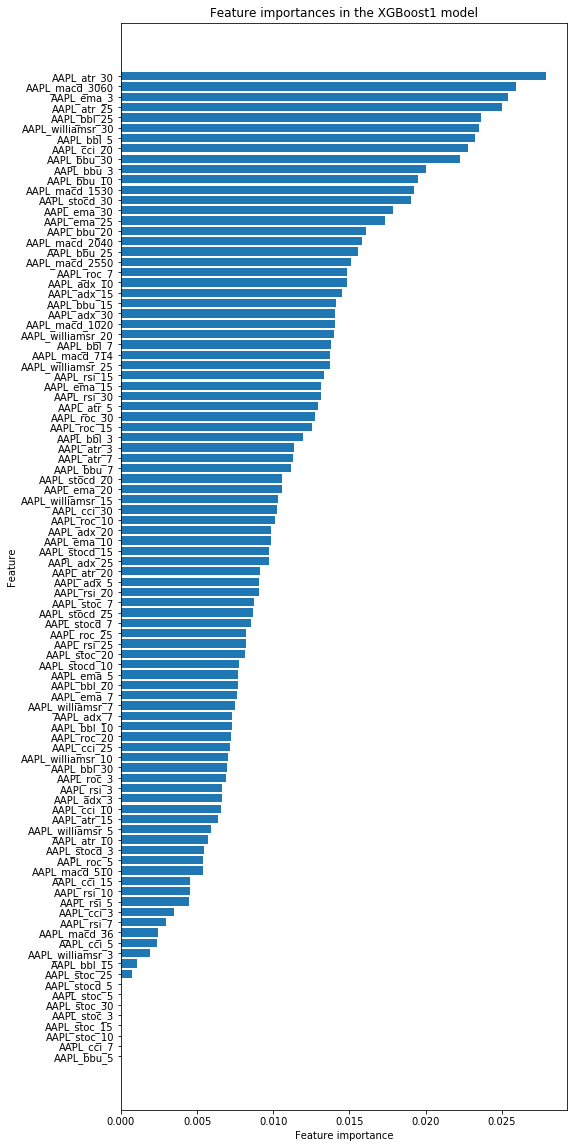

In [498]:
X1 = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y1 = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    print(X_train, X_test)

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0] TEST: [1]
[[1 2]] [[3 4]]
TRAIN: [0 1] TEST: [2]
[[1 2]
 [3 4]] [[1 2]]
TRAIN: [0 1 2] TEST: [3]
[[1 2]
 [3 4]
 [1 2]] [[3 4]]
TRAIN: [0 1 2 3] TEST: [4]
[[1 2]
 [3 4]
 [1 2]
 [3 4]] [[1 2]]
TRAIN: [0 1 2 3 4] TEST: [5]
[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]] [[3 4]]


## Unsupervised Learning

### KMeans Clustering

In [738]:
from sklearn.cluster import KMeans

In [763]:
kmeans = KMeans(
    n_clusters=3,
    verbose=0,
    tol=1E-3,
    max_iter=1000,
    n_init=20,
    random_state=3
)

In [764]:
kmeans.fit(X_scaled[['AAPL_macd_10', 'AAPL_williamsr_10']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=3, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=3, tol=0.001, verbose=0)

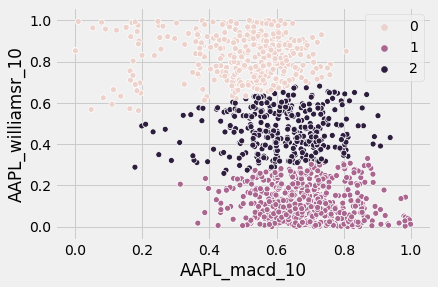

In [765]:
sns.scatterplot(X_scaled['AAPL_macd_10'], X_scaled['AAPL_williamsr_10'], hue=kmeans.labels_)

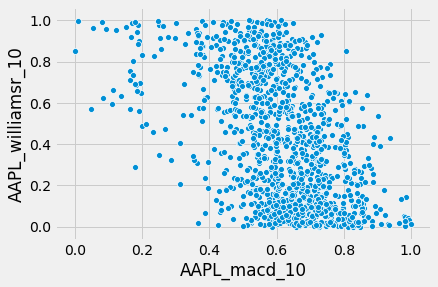

In [766]:
sns.scatterplot(X_scaled['AAPL_macd_10'], X_scaled['AAPL_williamsr_10'])